In [47]:
# basic packages
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
import os 

# packages for models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# packages for evaluation
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

In [2]:
# import dataset
data_train = pd.read_csv("adult_train.csv")
data_test = pd.read_csv("adult_test.csv")

In [3]:
# add a row to indicate the names of each column
data_train.columns =['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_Num', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Week', 'Native_Country', 'Label']
data_test.columns = ['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_Num', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Week', 'Native_Country', 'Label']

In [4]:
# drop unknown cols and cols with large numbers of variations to reduce tuning time
data_train = data_train.drop(['Fnlwgt','Native_Country'], axis = 1)
data_test = data_test.drop(['Fnlwgt','Native_Country'], axis = 1)

In [5]:
# change label to integer type to avoid uncompatible data type during training
data_train['Label'] = data_train['Label'].astype('category')
data_train['Label'] = data_train['Label'].cat.codes
data_test['Label'] = data_test['Label'].astype('category')
data_test['Label'] = data_test['Label'].cat.codes
label_train = data_train['Label']
label_test = data_test['Label']

In [6]:
# extract X
data_train = data_train.drop('Label', axis = 1)
data_test = data_test.drop('Label', axis = 1)

In [7]:
# change categorical variables to numerical for compatibility
data_train = pd.get_dummies(data_train, columns=['Workclass', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex'])
data_test = pd.get_dummies(data_test, columns=['Workclass', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex'])

In [8]:
# get the Naive Bayes Classifier Object
nb = GaussianNB()

In [9]:
nb.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [10]:
# list some possible values of var_smoothing
var_smoothing = [1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2]

In [11]:
# put these values in a parameter grid
parameter_grid = {
    'var_smoothing': var_smoothing
}

In [12]:
# input grid_search_cv's parameters
grid_search_cv = GridSearchCV(
    nb, parameter_grid, scoring="accuracy", n_jobs=-1, cv=5
)

In [13]:
%%time
# fit the training data using grid_search_cv to tune the hyperparameter
grid_search_cv.fit(data_train, label_train)

Wall time: 6.48 s


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05,
                                           0.0001, 0.001, 0.01]},
             scoring='accuracy')

In [14]:
# print the best value for the parameter var_smoothing
print(grid_search_cv.best_params_['var_smoothing'])

1e-09


In [15]:
# change the hyperparameter(s) according to the result of grid_search_cv
nb = GaussianNB(var_smoothing = 1e-09)

In [16]:
%%time
# fit the training dataset
nb = nb.fit(data_train, label_train)

Wall time: 43.7 ms


In [17]:
%%time
# prediction
predicted = nb.predict(data_test)

Wall time: 23.2 ms


In [18]:
# check acc
metrics.accuracy_score(label_test, predicted)

0.807923832923833

In [19]:
# check confusion matrix
print(confusion_matrix(label_test, predicted))

[[10011  2423]
 [  704  3142]]


In [20]:
# check classification report
print(classification_report(label_test, predicted))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86     12434
           1       0.56      0.82      0.67      3846

    accuracy                           0.81     16280
   macro avg       0.75      0.81      0.77     16280
weighted avg       0.85      0.81      0.82     16280



In [21]:
# check AUC for ROC curve
false_positive_rate, true_positive_rate, threshold = roc_curve(label_test, predicted)
auc = auc(false_positive_rate, true_positive_rate)
auc

0.8110418851368821

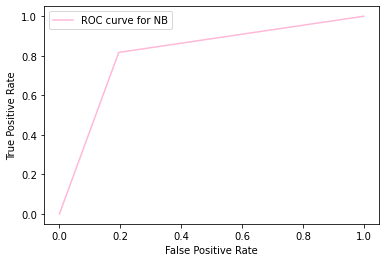

In [22]:
plt.plot(false_positive_rate, true_positive_rate, color='#FFB8D8', label='ROC curve for NB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [23]:
# compare with logistic regression model
# get instance of logistic regression
lr = LogisticRegression()

In [24]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [25]:
# list some possible values for the three most important hyperparameters
C = [0.001, 0.01, 0.1, 1, 10, 100]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l1', 'l2', 'elasticnet']

In [27]:
# put these values in a parameter grid
parameter_grid = {
    'C': C,
    'solver': solver,
    'penalty': penalty
}

In [28]:
# use random_search_cv instead to reduce time since too many combinations
# input random_search_cv's parameters
random_search_cv = RandomizedSearchCV(
    lr, parameter_grid, n_iter=20, scoring="accuracy", n_jobs=-1, cv=5
)

In [29]:
%%time
# fit the training data using random_search_cv to tune the hyperparameter
random_search_cv.fit(data_train, label_train)

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.7916769  0.85061425 0.78682432        nan        nan        nan
        nan 0.84112408        nan        nan 0.85033784 0.7916769
 0.7916769         nan        nan 0.78685504 0.85012285 0.84563882
 0.78682432        nan]
  warnings.warn(


Wall time: 52.9 s


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   scoring='accuracy')

In [31]:
# print the best value for the parameter var_smoothing
for k, v in random_search_cv.best_params_.items():
    print(f'{k}: {v}')

solver: newton-cg
penalty: l2
C: 1


In [32]:
# change the hyperparameter(s) according to the result of random_search_cv
lr = LogisticRegression(solver = 'newton-cg', penalty = 'l2', C = 1)

In [33]:
%%time
# fit the training dataset
lr = lr.fit(data_train, label_train)

Wall time: 9.39 s


In [34]:
%%time
# prediction
predicted = lr.predict(data_test)

Wall time: 13.8 ms


In [35]:
# check acc
metrics.accuracy_score(label_test, predicted)

0.8519041769041769

In [36]:
# check confusion matrix
print(confusion_matrix(label_test, predicted))

[[11580   854]
 [ 1557  2289]]


In [37]:
# check classification report
print(classification_report(label_test, predicted))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     12434
           1       0.73      0.60      0.66      3846

    accuracy                           0.85     16280
   macro avg       0.80      0.76      0.78     16280
weighted avg       0.85      0.85      0.85     16280



In [48]:
# check AUC for ROC curve
false_positive_rate, true_positive_rate, threshold = roc_curve(label_test, predicted)
auc = auc(false_positive_rate, true_positive_rate)
auc

0.7632405810950148

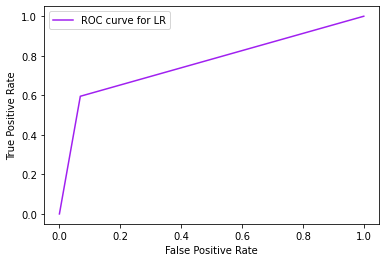

In [49]:
plt.plot(false_positive_rate, true_positive_rate, color='#A020F0', label='ROC curve for LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()